In [ ]:
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import zipfile
import io
from PIL import Image
import os
import csv
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class DeepArchitecture(nn.Module):
    def __init__(self, embed_size):
        super(DeepArchitecture, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(3, 32, 5), nn.ReLU(),  # in_channels, out_channels, kernel_size,  kernel size, stride, num kernels
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(32, 64, 5), nn.ReLU(),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(64, 128, 5), nn.ReLU(),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(128, 256, 5), nn.ReLU(),
                                     nn.MaxPool2d(2))

        self.fc = nn.Sequential(nn.Linear(256*121, 2*embed_size),
                                nn.ReLU(),
                                nn.Linear(2*embed_size, 2*embed_size),
                                nn.ReLU(),
                                nn.Linear(2*embed_size, embed_size))

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output


class FaceNet(nn.Module):
    def __init__(self, embed_size, is_train):
        super(FaceNet, self).__init__()
        self.deep_arch = DeepArchitecture(embed_size=embed_size)
        self.is_train = is_train

    def forward(self, x1, x2, x3):
        if self.is_train:
          output1 = self.deep_arch(x1)
          output2 = self.deep_arch(x2)
          output3 = self.deep_arch(x3)
          output1 = torch.nn.functional.normalize(output1)
          output2 = torch.nn.functional.normalize(output2)
          output3 = torch.nn.functional.normalize(output3)
          return output1, output2, output3
        else:
          output1 = self.deep_arch(x1)
          output1 = torch.nn.functional.normalize(output1)
          return output1

In [ ]:
model = FaceNet(embed_size=128, is_train=True)
if torch.cuda.is_available():
    model.cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/cv22.pth"))
lr = 1e-3
wd = 1e-5
optimizer = optim.Adam(params=model.parameters(), lr=lr, weight_decay=wd)

In [ ]:
archive15 = zipfile.ZipFile('/content/drive/MyDrive/test_set15.zip', 'r')
archive15.extractall()
archive9 = zipfile.ZipFile('/content/drive/MyDrive/test_set9.zip', 'r')
archive9.extractall()

In [ ]:
df_np = np.genfromtxt("/content/drive/MyDrive/embed_list_np22.csv", delimiter=',')
df_names = pd.read_csv("/content/drive/MyDrive/embed_list_names22.csv", sep=',', header=None)

In [9]:
def test_model(model, use_cuda, embed_list, name_list, file_path = '/content/test_set15'):
  
  model.eval()
  with torch.no_grad():
        acc = 0
        result_list = []
        for index in range(len(os.listdir(file_path))):

          euc_dist = 0
          imgFile1 = file_path + '/' + os.listdir(file_path)[index] + '/' + os.listdir(file_path)[index] + '_0015.jpg'

          imgFile2 = file_path + '/' + os.listdir(file_path)[index] + '/' + os.listdir(file_path)[index] + '_0002.jpg'
          img1, label1 = np.array(Image.open(imgFile1), dtype='float32'), os.listdir(file_path)[index]
          img2 = np.array(Image.open(imgFile2), dtype='float32')


          img1 = np.transpose(img1, (2, 0, 1))
          img2 = np.transpose(img2, (2, 0, 1))

          
          inputs = (img1, img2, img2)
          if torch.cuda.is_available():
            inputs = list(torch.tensor(inps).to('cuda', dtype=torch.float) for inps in inputs)
          optimizer.zero_grad()
          embed1, embed2, embed3 = model(torch.unsqueeze(inputs[0], axis=0), torch.unsqueeze(inputs[1], axis=0), torch.unsqueeze(inputs[2], axis=0))
          euclidean_distance = F.pairwise_distance(embed1, embed2)
          min_dist = euclidean_distance
          label_min = label1
          for idx in range(len(embed_list)):
              euc_dist = F.pairwise_distance(embed1, torch.tensor(embed_list[idx]).to('cuda', dtype=torch.float))
              if euc_dist < min_dist and euc_dist > 0.00005 and euc_dist < 0.01:
                  min_dist = euc_dist
                  label_min = name_list[idx][0]
          result_list.append([label1, label_min])
          if label_min == label1:
            acc += 1
        print(f"Accuracy of {len(os.listdir(file_path))} different actors' images is: " + str(acc / len(os.listdir(file_path)) * 100) + '%')
        return result_list

In [10]:
model = FaceNet(embed_size=128, is_train=True)
if torch.cuda.is_available():
    model.cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/cv22.pth"))
result_list = test_model(model, True, df_np, df_names)

Accuracy of 96 different actors' images is: 32.29166666666667%


Test label: Venus_Williams 	 Prediction: Venus_Williams


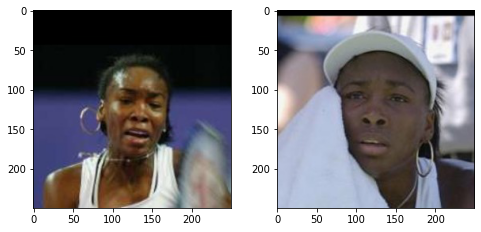

In [12]:
fig = plt.figure(figsize=(8, 8))
file_path = '/content/test_set15'
model.eval()

with torch.no_grad():

    euc_dist = 0
    index = 24
    imgFile1 = file_path + '/' + os.listdir(file_path)[index] + '/' + os.listdir(file_path)[index] + '_0015.jpg'

    imgFile2 = file_path + '/' + os.listdir(file_path)[index] + '/' + os.listdir(file_path)[index] + '_0003.jpg'
    img1, label1 = np.array(Image.open(imgFile1), dtype='float32'), os.listdir(file_path)[index]
    label1 = os.listdir(file_path)[index]
    img2 = np.array(Image.open(imgFile2), dtype='float32')


    img1 = np.transpose(img1, (2, 0, 1))
    img2 = np.transpose(img2, (2, 0, 1))

    inputs = (img1, img2, img2) # the last img2 is seen as negative pair, since it's not training that is not a problem
    if torch.cuda.is_available():
      inputs = list(torch.tensor(inps).to('cuda', dtype=torch.float) for inps in inputs)
    optimizer.zero_grad()
    embed1, embed2, embed3 = model(torch.unsqueeze(inputs[0], axis=0), torch.unsqueeze(inputs[1], axis=0), torch.unsqueeze(inputs[2], axis=0))
    euclidean_distance = F.pairwise_distance(embed1, embed2) # starting euclidean distance value for the comparison
    min_dist = euclidean_distance
    label_min = label1
    img_name = imgFile2
    for idx in range(len(df_np)):
        euc_dist = F.pairwise_distance(embed1, torch.tensor(df_np[idx]).to('cuda', dtype=torch.float))
        if euc_dist < min_dist and euc_dist > 0.00005 and euc_dist < 0.01: # thresholds to eliminate the really small distances and also the big ones
            min_dist = euc_dist
            label_min, img_name = df_names[idx][0], df_names[idx][1]
    name1, name2 = label1, label_min
    text = f"Test label: {name1} \t Prediction: {name2}"
    img_name2 = '/content/test_set9' + '/' + label_min + '/' + label_min + img_name[-9:]
    img4 = np.array(Image.open(img_name2), dtype='float32')
    print(text)
    fig.add_subplot(2,2,1)
    plt.imshow(Image.fromarray( np.asarray( np.clip(np.array(torch.permute(inputs[0], (1, 2, 0)).cpu()),0,255), dtype="uint8"), "RGB" ))
    fig.add_subplot(2,2,2)
    plt.imshow(Image.fromarray( np.asarray( np.clip(img4, 0, 255), dtype="uint8"), "RGB" ))
plt.show()